# Project 3: Battery Equivalent Circuit Model Design
>**Date Created**: 19 February 2024<br>
>**Course**: AEM566 - Optimal Estimation<br>
>**Author**: Benjamin Lucke<br>

In [396]:
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
from scipy.integrate import trapezoid, simpson

### 1. Load the battery data for the pulse discharge tests in the accompanying CSV file

In [567]:
data = pd.read_csv('data/pulse_discharge_test_data.csv')
# rename columns to make easier to reference and convert times to datetime for convenience
columnMapper = dict(zip(data.columns.values,['t', 'v', 'i'],)) 
data = data.rename(columns=columnMapper)
data['t'] = pd.to_datetime(data['t'],format="%H:%M:%S")

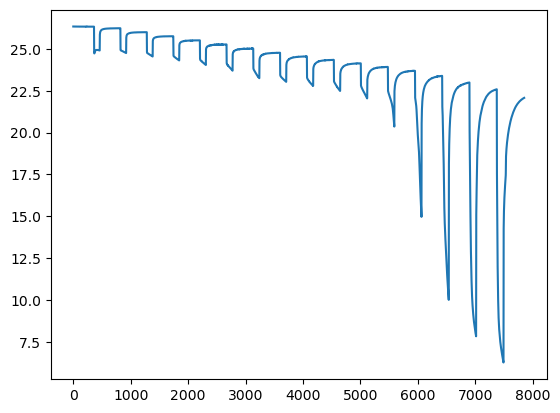

In [777]:
plt.plot(data['v'])

### 2. Numerically integrate the current to obtain the SOC for the entire data set

In [574]:
soc_full = simpson(data['i'], dx = 10)

### 3. Partition the data into each rest period using the current measurement as the trigger

Text(0, 0.5, 'Current (amperes)')

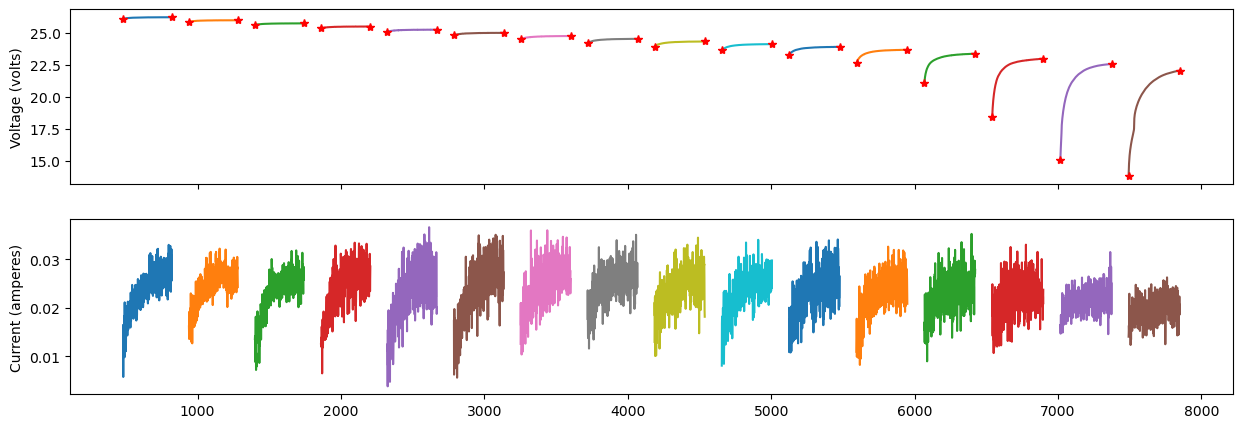

In [719]:
data['i_diff'] = data.loc[:,'i'].diff()
delta_indices = data[(data['i_diff']) > .1].index.tolist() # Get indices based on differnetial in current
pairs = list()

# Create grouped pairs of indices where rest period starts and ends
for k, index in enumerate(delta_indices):
    if k == len(delta_indices)-1:
        pair = index + 118, data.index[-1] # +118 was by trial and error, gave consistently ok results of rest period indices
    else:
        pair = index + 118, delta_indices[k+1]
    pairs.append(pair)
pairs = np.array(pairs)
fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1, figsize=(15,5),sharex=True)
for k, (start, end) in enumerate(pairs):
    ax1.plot(data.iloc[start:end, 1])
    ax2.plot(data.iloc[start:end, 2])
    ax1.plot(start, data.iloc[start,1],'r*')
    ax1.plot(end, data.iloc[start:end,1].iloc[-1],'r*')
ax1.set_ylabel('Voltage (volts)')
ax2.set_ylabel('Current (amperes)')

In [638]:
def initial_estimate_r0(rest_start, rest_end):
    v_ts = data.iloc[rest_start - 1,1] # get voltage at time step before rest period starts
    v_tr_0 = data.iloc[rest_start, 1] # get voltage at start of rest period
    lhs = v_tr_0 - v_ts # Compute difference in voltages
    r0_est = lhs/data.iloc[rest_start,2] # divide by current to get estimate of R0
    return r0_est

In [723]:
def initial_estimate_r1(rest_start, rest_end):
    ocv = data.iloc[rest_start:rest_end, 1].iloc[-1] # use voltage at end of rest period as crude estimate to OCV
    v_tr_0 = data.iloc[rest_start, 1] 
    i_dis = data.iloc[rest_start,2]
    i_dis_R1 = 0.95*(ocv - v_tr_0) # get quantity i_dis * R_1
    r1_est = 0.95*(ocv - v_tr_0)/i_dis # divide by i_dis at start of rest period to get estimate of R_1
    return i_dis_R1, r1_est 

In [774]:
def initial_estimate_tau1(rest_start, rest_end):
    rhs, _ = initial_estimate_r1(rest_start, rest_end)
    v_tr_0 = data.iloc[rest_start, 1] 
    
    # Loop through indices between rest period start and end to find first index >= .95*(OCV - V_tr_0)
    for k in range(rest_start, rest_end):
        v_tr_candidate = data.iloc[k, 1]
        result = v_tr_candidate - v_tr_0
        if result >= rhs:
            first_larger_index = k
            break
            
    v_tr = data.iloc[first_larger_index, 1]
    thrice_tau1 = 10*(first_larger_index - rest_start)
    tau_1_est = (thrice_tau1/3)
    return tau_1_est
    

In [790]:
# Get initial guesses of parameters R0, R1, and tau_1 for each rest period
initial_estimates = np.zeros((len(pairs[:,0]), 3))
for k in range(len(pairs[:,0])):
    r0_est, (_, r1_est), tau1_est = initial_estimate_r0(*pairs[k]),  initial_estimate_r1(*pairs[k]),  initial_estimate_tau1(*pairs[k])
    initial_estimates[k] = r0_est, r1_est, tau1_est

In [630]:
def first_order_approx():
    return ocv - i_t*R_1*np.exp(-t_r/tau)
def second_order_approx():
    return ocv - i_t*R_1*np.exp(-t_r/10*tau) - i_t*R_2*np.exp(-t_r/10*tau)
def third_order_approx():
    return ocv - i_t*R_1*np.exp(-t_r/10*tau) - i_t*R_2*np.exp(-t_r/10*tau) - i_t*R_3np.exp(-t_r/10*tau)